# Model Comparison Notebook

This notebook provides tools for comparing performance across different trained models:
- test set accuracy evaluation
- confusion matrix analysis
- per-class and group accuracy
- dropout vs. overfitting plots
- efficiency vs. accuracy tradeoffs


In [1]:
# Standard library
import sys
import os
import numpy as np

# Project root and paths
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from utils.paths import MODELS_DIR, DATA_DIR, ARCHITECTURES_DIR

# Data and evaluation utilities
from utils.data_utils import evaluate_all_models_on_test

# Visualization tools
from utils.visualization import (
    display_df,
    build_comparison_table, plot_model_comparison,
    plot_val_vs_test_acc, plot_dropout_vs_overfit,
    plot_efficiency, plot_group_accuracy,
    interactive_model_comparison,
    plot_correlation_heatmap, plot_feature_importance, plot_scatter_metrics, plot_boxplot_by_category,
    build_extended_table
)


## Model Performance Summary

This section summarizes all trained models with key metrics:
- Best validation accuracy and training accuracy
- Overfitting gap and stability
- Average epoch time and optimizer used


,Model,Type,Architecture,Optimizer,Dropout,LR,Epoch (best),Train Acc,Val Acc,Val Loss,Overfit Gap,Avg Epoch Time (s),Converged by Epoch,Stability (val acc)
0,densenet121_opt-adam_aug-on,CIFAR10_DenseNet121,Standard,Adam (lr=0.001),N/A,0.001000,77,0.537400,0.917400,0.297800,-0.380000,117.820000,16,0.001832
1,resnet18_opt-adam_aug-on,CIFAR10_ResNet18,Standard,Adam (lr=0.001),N/A,0.001000,82,0.533200,0.900100,0.339300,-0.366900,54.760000,17,0.002855
2,cnn_320-1920_deepdrop_sched-plateau_mixup0.4_resize126_batch,CIFAR10_DeepDropoutCNN,"conv: [320, 320, 640, 640, 960, 960, 1280, 1280, 1600, 1600, 1920, 1920], batch_norm: True",Adam (lr=0.001),"[0.0, 0.0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5]",0.001000,74,0.443200,0.826200,0.535800,-0.383000,503.200000,32,0.002526
3,cnn_32-64-128-bn_fc-512-256_opt-adam_aug-on,CIFAR10_CNN,"conv: [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}], fc: [512, 256]",Adam (lr=0.001),"[0.5, 0.5]",0.001000,95,0.403300,0.754300,0.780900,-0.351000,27.340000,24,0.002963
4,cnn_32-64-128-bn_fc-512-256_leakyrelu_aug-on,CIFAR10_CNN,"conv: [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}], fc: [512, 256]",Adam (lr=0.001),"[0.5, 0.5]",0.001000,89,0.412800,0.745700,0.802200,-0.332900,44.810000,23,0.002675
5,cnn_32-64_fc-256_mixup-only,CIFAR10_CNN,"conv: [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}], fc: [256]",Adam (lr=0.001),[0.5],0.001000,19,0.500700,0.743500,0.795100,-0.242800,18.890000,3,0.001585
6,cnn_32-64-128-bn_fc-512-256_gs-on,CIFAR10_CNN,"conv: [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}], fc: [512, 256]",Adam (lr=0.001),"[0.5, 0.5]",0.001000,76,0.407400,0.742300,0.837200,-0.334900,26.760000,22,0.002860
7,cnn_32-64-128_fc-512-256_nobn_aug-on,CIFAR10_CNN,"conv: [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}, {'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}], fc: [512, 256]",Adam (lr=0.001),"[0.5, 0.5]",0.001000,58,0.387600,0.739000,0.842900,-0.351400,44.660000,19,0.003169
8,cnn_32-64_fc-256_noaug,CIFAR10_CNN,"conv: [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}], fc: [256]",Adam (lr=0.001),[0.5],0.001000,10,0.864400,0.731800,0.942200,0.132600,16.830000,3,0.003834
9,cnn_64-128-bn_fc-512-256_mix-alpha0.2,CIFAR10_CNN,"conv: [{'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}], fc: [512, 256]",Adam (lr=0.001),"[0.5, 0.5]",0.001000,70,0.388400,0.710300,0.896700,-0.321900,26.670000,28,0.003164


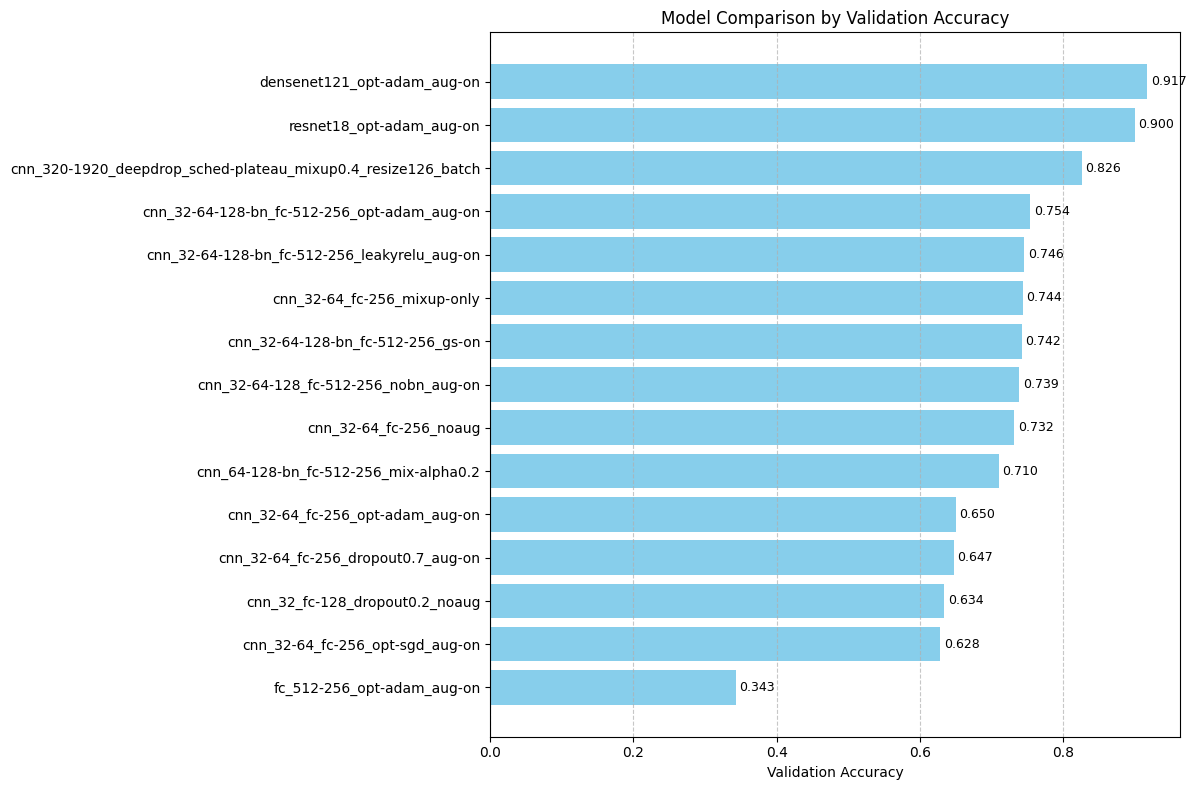

✅ Best model: densenet121_opt-adam_aug-on with 0.9174 val accuracy


In [2]:
df_models = build_comparison_table(models_dir=MODELS_DIR).sort_values(by="Val Acc", ascending=False)
styled_df_models = df_models.style.bar(subset=["Val Acc", "Train Acc", "Overfit Gap", "Stability (val acc)"], color='lightblue')
display(styled_df_models)

plot_model_comparison(df_models)

best_model = df_models.loc[df_models["Val Acc"].idxmax()]
print(f"✅ Best model: {best_model['Model']} with {best_model['Val Acc']:.4f} val accuracy")

#### Evaluate Models on Test Set

In this section, each trained model is evaluated on the test dataset.

- ✅ If cached results exist (`force=False`), they are loaded to save time.
- 🔁 If needed, set `force=True` to re-run the evaluation and overwrite cached results.
- 💾 Test predictions are saved to JSON files (`save_predictions=True`) to allow for later analysis and visualization.

In [3]:
# Evaluate all models on the test set and update main table
print("\n📊 Evaluating all models on the test set...\n")
test_results, class_names = evaluate_all_models_on_test(models_dir=MODELS_DIR, force=False, save_predictions=True)

for model_name, metrics in test_results.items():
    if model_name in df_models["Model"].values:
        df_models.loc[df_models["Model"] == model_name, "Test Acc"] = round(metrics["accuracy"], 4)
        df_models.loc[df_models["Model"] == model_name, "Test Loss"] = round(metrics["loss"], 4)

print(f"\n✅ Updated test accuracy and loss for {len(test_results)} models.")


📊 Evaluating all models on the test set...

------------------------------------------------------------
Evaluating archive...
------------------------------------------------------------
------------------------------------------------------------
Evaluating cnn_32-64-128-bn_fc-512-256_gs-on...
------------------------------------------------------------
✅ Test results already exist for cnn_32-64-128-bn_fc-512-256_gs-on.. loading from c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\models\cnn_32-64-128-bn_fc-512-256_gs-on\cnn_32-64-128-bn_fc-512-256_gs-on_test.json
------------------------------------------------------------
Evaluating cnn_32-64-128-bn_fc-512-256_leakyrelu_aug-on...
------------------------------------------------------------
✅ Test results already exist for cnn_32-64-128-bn_fc-512-256_leakyrelu_aug-on.. loading from c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\models\cnn_32-64-128-bn_fc-512-256_leakyrelu_aug-on\cn

,Model,Type,Architecture,Optimizer,Dropout,LR,Epoch (best),Train Acc,Val Acc,Test Acc,Val Loss,Test Loss,Overfit Gap,Avg Epoch Time (s),Converged by Epoch,Stability (val acc)
0,densenet121_opt-adam_aug-on,CIFAR10_DenseNet121,Standard,Adam (lr=0.001),N/A,0.001000,77,0.537400,0.917400,0.938000,0.297800,0.215300,-0.380000,117.820000,16,0.001832
1,resnet18_opt-adam_aug-on,CIFAR10_ResNet18,Standard,Adam (lr=0.001),N/A,0.001000,82,0.533200,0.900100,0.927500,0.339300,0.239500,-0.366900,54.760000,17,0.002855
2,cnn_320-1920_deepdrop_sched-plateau_mixup0.4_resize126_batch,CIFAR10_DeepDropoutCNN,"conv: [320, 320, 640, 640, 960, 960, 1280, 1280, 1600, 1600, 1920, 1920], batch_norm: True",Adam (lr=0.001),"[0.0, 0.0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5]",0.001000,74,0.443200,0.826200,0.865400,0.535800,0.422300,-0.383000,503.200000,32,0.002526
3,cnn_32-64-128-bn_fc-512-256_opt-adam_aug-on,CIFAR10_CNN,"conv: [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}], fc: [512, 256]",Adam (lr=0.001),"[0.5, 0.5]",0.001000,95,0.403300,0.754300,0.819400,0.780900,0.583100,-0.351000,27.340000,24,0.002963
4,cnn_32-64-128-bn_fc-512-256_leakyrelu_aug-on,CIFAR10_CNN,"conv: [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}], fc: [512, 256]",Adam (lr=0.001),"[0.5, 0.5]",0.001000,89,0.412800,0.745700,0.804200,0.802200,0.626100,-0.332900,44.810000,23,0.002675
6,cnn_32-64-128-bn_fc-512-256_gs-on,CIFAR10_CNN,"conv: [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}], fc: [512, 256]",Adam (lr=0.001),"[0.5, 0.5]",0.001000,76,0.407400,0.742300,0.795800,0.837200,0.648700,-0.334900,26.760000,22,0.002860
9,cnn_64-128-bn_fc-512-256_mix-alpha0.2,CIFAR10_CNN,"conv: [{'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}, {'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True, 'batch_norm': True}], fc: [512, 256]",Adam (lr=0.001),"[0.5, 0.5]",0.001000,70,0.388400,0.710300,0.786500,0.896700,0.658700,-0.321900,26.670000,28,0.003164
7,cnn_32-64-128_fc-512-256_nobn_aug-on,CIFAR10_CNN,"conv: [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}, {'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}], fc: [512, 256]",Adam (lr=0.001),"[0.5, 0.5]",0.001000,58,0.387600,0.739000,0.786300,0.842900,0.656600,-0.351400,44.660000,19,0.003169
10,cnn_32-64_fc-256_opt-adam_aug-on,CIFAR10_CNN,"conv: [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}], fc: [256]",Adam (lr=0.001),[0.5],0.001000,70,0.378100,0.650100,0.743900,1.042200,0.768600,-0.272000,30.730000,22,0.003825
11,cnn_32-64_fc-256_dropout0.7_aug-on,CIFAR10_CNN,"conv: [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}], fc: [256]",Adam (lr=0.001),[0.7],0.001000,74,0.374500,0.647300,0.739700,1.067100,0.770800,-0.272800,44.770000,27,0.005483


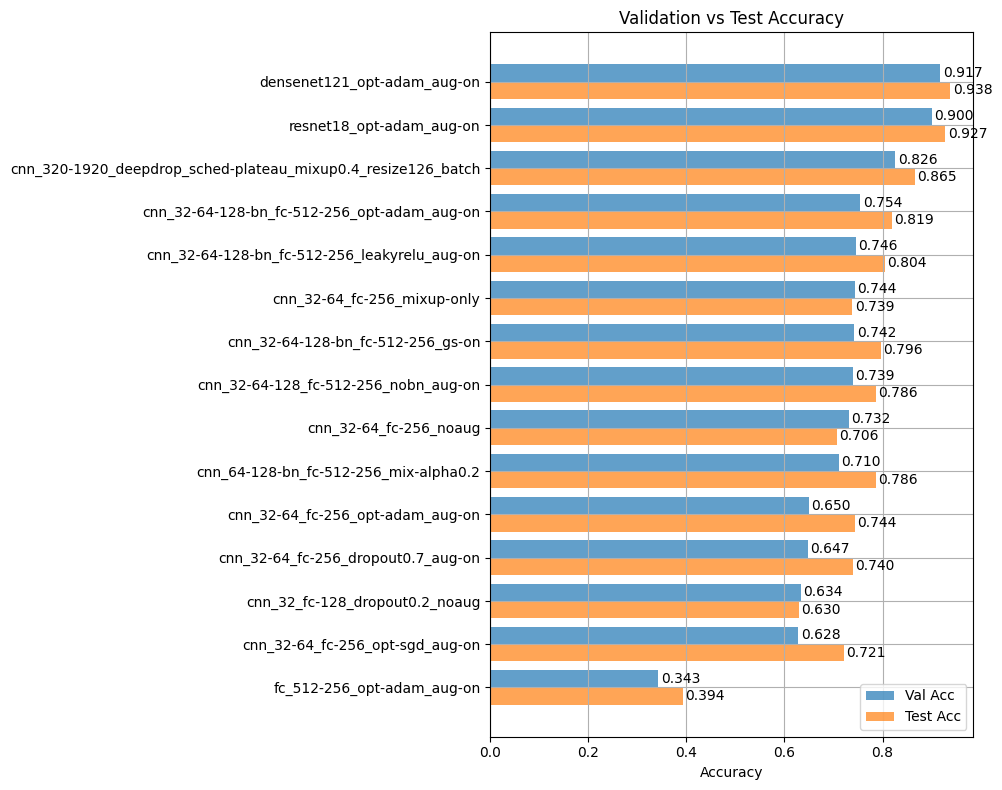

In [4]:
columns_order = [
    "Model", "Type", "Architecture", "Optimizer", "Dropout", "LR",
    "Epoch (best)", "Train Acc", "Val Acc", "Test Acc",
    "Val Loss", "Test Loss", "Overfit Gap",
    "Avg Epoch Time (s)", "Converged by Epoch", "Stability (val acc)"
]
df_models = df_models[columns_order]
styled_df_models = df_models.sort_values("Test Acc", ascending=False).style.bar(
    subset=["Val Acc", "Train Acc", "Test Acc"], color='lightblue'
)
display(styled_df_models)
plot_val_vs_test_acc(df_models)

#### Correlation Heatmap of Model Metrics

This heatmap visualizes the pairwise correlations between all key numeric metrics collected during model training and evaluation. Each cell shows the Pearson correlation coefficient between two metrics, ranging from -1 (strong negative correlation) to +1 (strong positive correlation).

**How to interpret:**
- **Red (positive values):** Metrics tend to increase together.  
- **Blue (negative values):** When one metric increases, the other tends to decrease.
- **Values near zero:** Little or no linear relationship.

**Typical insights you can gain:**
- Identify which hyperparameters and metrics (e.g., overfitting gap, average epoch time, stability) are most strongly associated with high validation/test accuracy.
- Spot potential trade-offs, such as speed vs. accuracy or dropout vs. overfitting.
- Detect redundant or highly collinear metrics.

**How to use:**  
Use this plot to prioritize which metrics and model characteristics to tune for better performance, and to understand the dynamics of your experiments at a glance.


In [5]:
df_ext_feauters_metrics = build_extended_table(MODELS_DIR)
for model_name, metrics in test_results.items():
    if model_name in df_ext_feauters_metrics["Model"].values:
        df_ext_feauters_metrics.loc[df_ext_feauters_metrics["Model"] == model_name, "Test Acc"] = round(metrics["accuracy"], 4)
        df_ext_feauters_metrics.loc[df_ext_feauters_metrics["Model"] == model_name, "Test Loss"] = round(metrics["loss"], 4)
display_df(df_ext_feauters_metrics, rows=0)

Model,Type,num_conv_layers,num_fc_layers,conv_channels_sum,batchnorm,activation_fn,dropout,input_size,grayscale,optimizer,lr,lr_scheduler,augmentation,mixup_alpha,cutout_size,Epoch (best),Train Acc,Val Acc,Val Loss,Overfit Gap,Avg Epoch Time (s),Converged by Epoch,Stability (val acc),n_params,param_size_mb,num_layers,num_bn_layers,num_relu_layers,num_dropout_layers,max_out_channels,has_dropout,layer_types,flops,Test Acc,Test Loss
cnn_32-64-128-bn_fc-512-256_gs-on,CIFAR10_CNN,3,3,224.0,True,ReLU,0.50,32,True,Adam,0.001,ReduceLROnPlateau,both,0.4,8.0,76,0.4074,0.7423,0.8372,-0.3349,26.762131,22,0.002860,1276618,4.870,22,4,4,1,128,True,"BatchNorm1d,BatchNorm2d,CIFAR10_CNN,Conv2d,Dropout,Flatten,Linear,MaxPool2d,ReLU,Sequential",11317514,0.7958,0.6487
cnn_32-64-128-bn_fc-512-256_leakyrelu_aug-on,CIFAR10_CNN,3,3,224.0,True,LeakyReLU,0.50,32,False,Adam,0.001,ReduceLROnPlateau,both,0.4,8.0,89,0.4128,0.7457,0.8022,-0.3329,44.811284,23,0.002675,1277194,4.872,22,4,4,1,128,True,"BatchNorm1d,BatchNorm2d,CIFAR10_CNN,Conv2d,Dropout,Flatten,LeakyReLU,Linear,MaxPool2d,Sequential",11849738,0.8042,0.6261
cnn_32-64-128-bn_fc-512-256_opt-adam_aug-on,CIFAR10_CNN,3,3,224.0,True,ReLU,0.50,32,False,Adam,0.001,ReduceLROnPlateau,both,0.4,8.0,95,0.4033,0.7543,0.7809,-0.3510,27.337005,24,0.002963,1277194,4.872,22,4,4,1,128,True,"BatchNorm1d,BatchNorm2d,CIFAR10_CNN,Conv2d,Dropout,Flatten,Linear,MaxPool2d,ReLU,Sequential",11907338,0.8194,0.5831
cnn_32-64-128_fc-512-256_nobn_aug-on,CIFAR10_CNN,3,3,224.0,False,ReLU,0.50,32,False,Adam,0.001,ReduceLROnPlateau,both,0.4,8.0,58,0.3876,0.7390,0.8429,-0.3514,44.655095,19,0.003169,1277194,4.872,22,4,4,1,128,True,"BatchNorm1d,BatchNorm2d,CIFAR10_CNN,Conv2d,Dropout,Flatten,Linear,MaxPool2d,ReLU,Sequential",11907338,0.7863,0.6566
cnn_32-64_fc-256_dropout0.7_aug-on,CIFAR10_CNN,2,2,96.0,False,ReLU,0.70,32,False,Adam,0.001,ReduceLROnPlateau,both,0.4,8.0,74,0.3745,0.6473,1.0671,-0.2728,44.766024,27,0.005483,1070986,4.085,14,2,2,0,64,False,"BatchNorm2d,CIFAR10_CNN,Conv2d,Flatten,Linear,MaxPool2d,ReLU,Sequential",6998794,0.7397,0.7708
cnn_32-64_fc-256_mixup-only,CIFAR10_CNN,2,2,96.0,False,ReLU,0.50,32,False,Adam,0.001,ReduceLROnPlateau,mixup,0.4,0.0,19,0.5007,0.7435,0.7951,-0.2428,18.894315,3,0.001585,1070986,4.085,14,2,2,0,64,False,"BatchNorm2d,CIFAR10_CNN,Conv2d,Flatten,Linear,MaxPool2d,ReLU,Sequential",6998794,0.7386,0.7924
cnn_32-64_fc-256_noaug,CIFAR10_CNN,2,2,96.0,False,ReLU,0.50,32,False,Adam,0.001,ReduceLROnPlateau,off,0.0,0.0,10,0.8644,0.7318,0.9422,0.1326,16.825588,3,0.003834,1070986,4.085,14,2,2,0,64,False,"BatchNorm2d,CIFAR10_CNN,Conv2d,Flatten,Linear,MaxPool2d,ReLU,Sequential",6998794,0.7060,0.8601
cnn_32-64_fc-256_opt-adam_aug-on,CIFAR10_CNN,2,2,96.0,False,ReLU,0.50,32,False,Adam,0.001,ReduceLROnPlateau,both,0.4,8.0,70,0.3781,0.6501,1.0422,-0.2720,30.729469,22,0.003825,1070986,4.085,14,2,2,0,64,False,"BatchNorm2d,CIFAR10_CNN,Conv2d,Flatten,Linear,MaxPool2d,ReLU,Sequential",6998794,0.7439,0.7686
cnn_32-64_fc-256_opt-sgd_aug-on,CIFAR10_CNN,2,2,96.0,False,ReLU,0.50,32,False,SGD,0.010,StepLR,both,0.4,8.0,63,0.3614,0.6284,1.1159,-0.2670,43.112595,19,0.004212,1070986,4.085,14,2,2,0,64,False,"BatchNorm2d,CIFAR10_CNN,Conv2d,Flatten,Linear,MaxPool2d,ReLU,Sequential",6998794,0.7205,0.8196
cnn_320-1920_deepdrop_sched-plateau_mixup0.4_resize126_batch,CIFAR10_DeepDropoutCNN,13,0,13440.0,True,LeakyReLU,0.25,126,False,Adam,0.001,ReduceLROnPlateau,both,0.4,8.0,74,0.4432,0.8262,0.5358,-0.3830,503.203931,32,0.002526,45733770,174.460,56,12,12,0,1920,False,"AdaptiveAvgPool2d,BatchNorm2d,CIFAR10_DeepDropoutCNN,Conv2d,Dropout2d,LeakyReLU,MaxPool2d,Sequential",22514530590,0.8654,0.4223


#### Hyperparameters analysis

Make sense to analyse features one type model

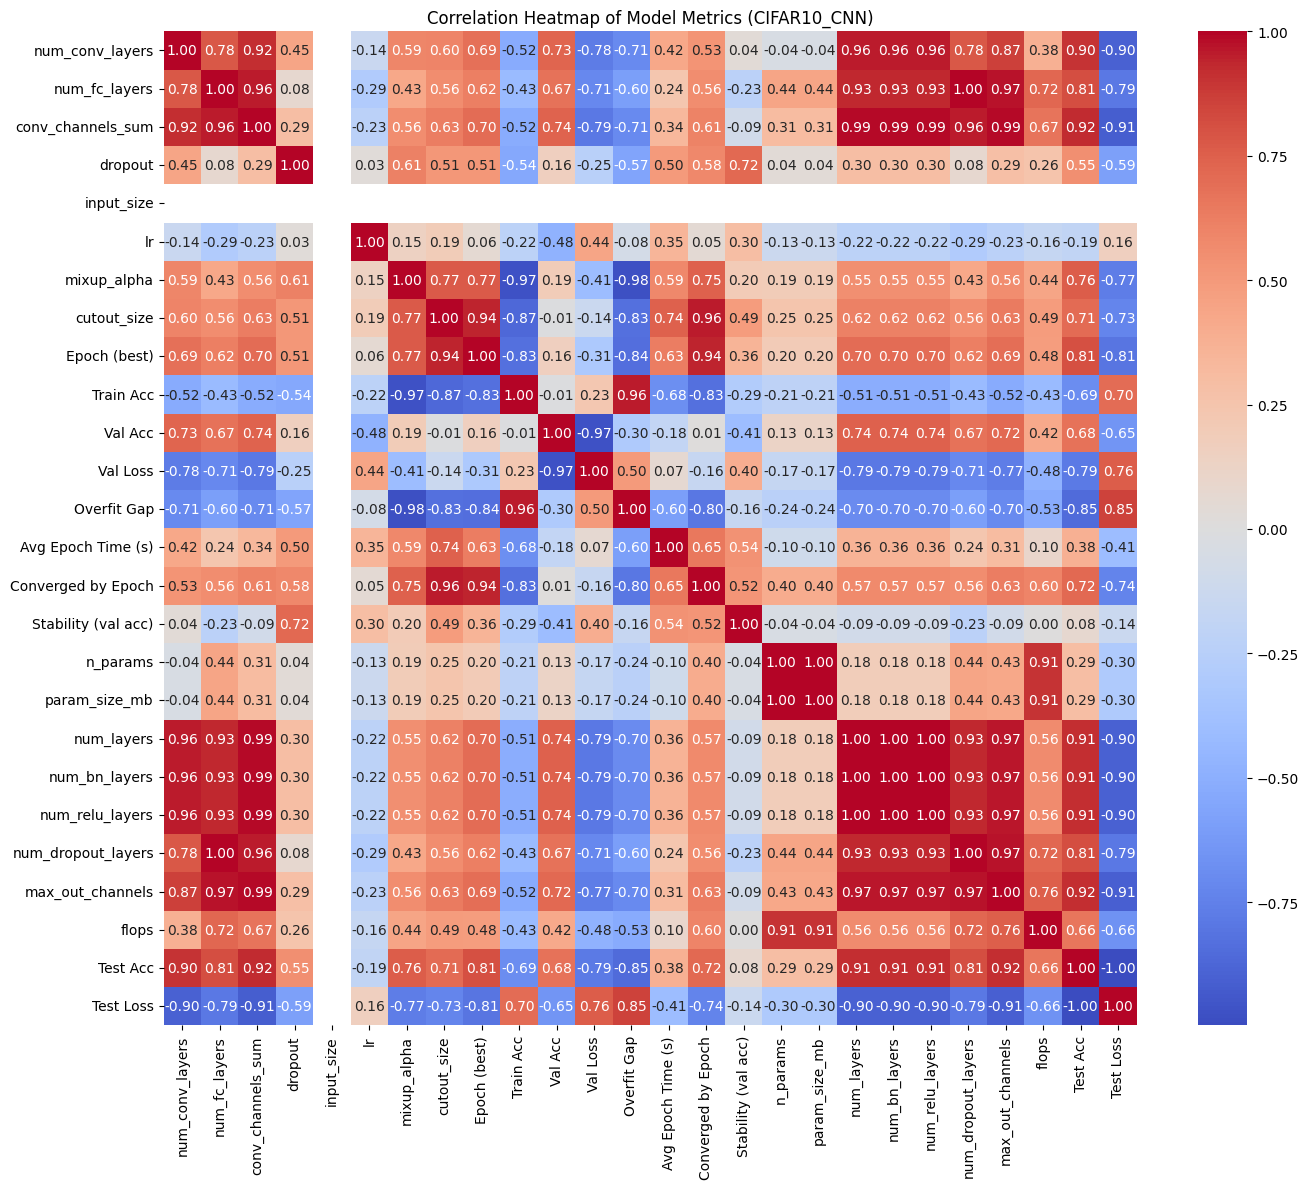

In [6]:
plot_correlation_heatmap(df_ext_feauters_metrics, filter_type="CIFAR10_CNN",figsize=(14,12))

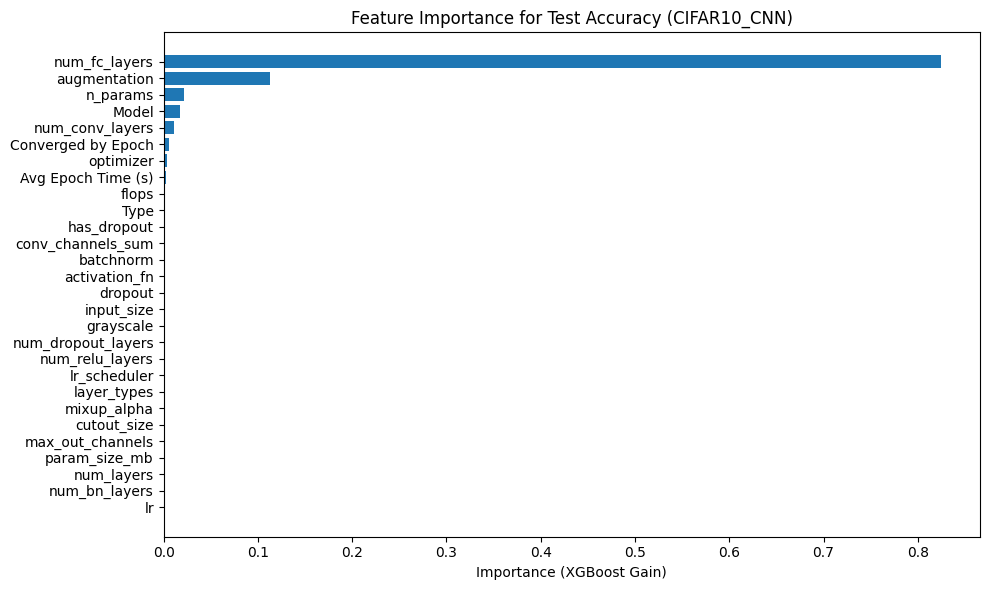

In [7]:
plot_feature_importance(df_ext_feauters_metrics, filter_type="CIFAR10_CNN", target_col="Test Acc")

#### Test Accuracy vs Training Speed

This scatter plot helps visualize the trade-off between test accuracy and training speed for all model architectures. Each point represents a model, positioned by its average epoch training time (seconds) and test accuracy.

**How to interpret:**
- Points towards the top-left are the most desirable: high accuracy with fast training.
- Larger, slower models (e.g., DenseNet/DeepDropout) tend to be further right, while lightweight models (e.g., shallow CNNs, FC) cluster left.
- This plot can guide architecture selection for scenarios where training speed is a constraint.

Use this analysis to select models that best fit your resource and deployment requirements.


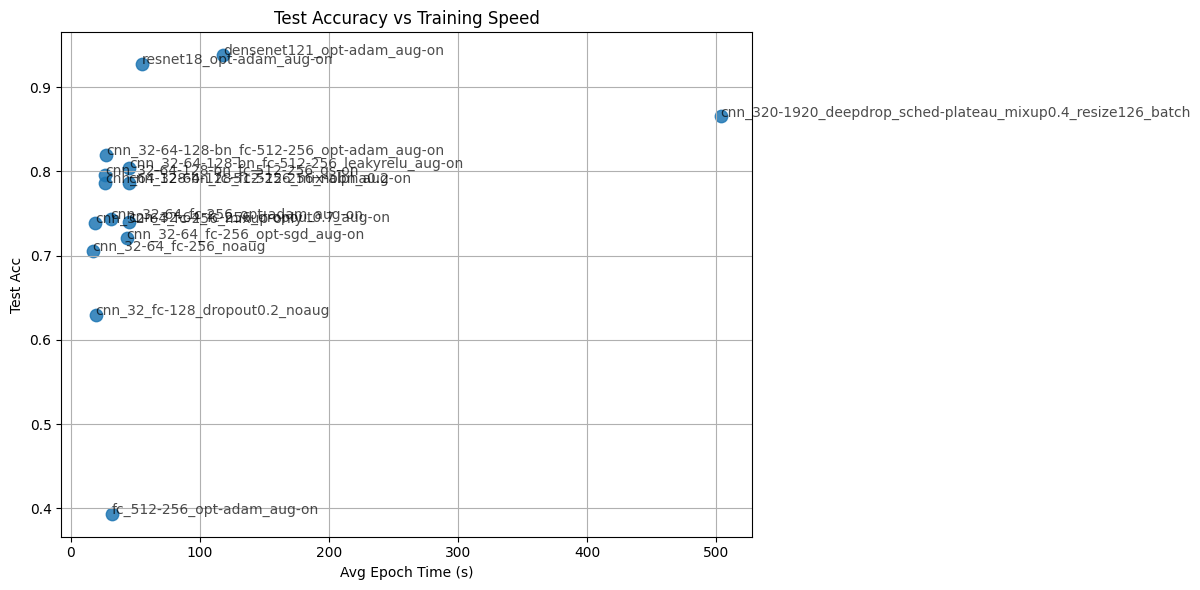

In [8]:
plot_scatter_metrics(
    df_ext_feauters_metrics,
    x_col='Avg Epoch Time (s)',
    y_col='Test Acc',
    label_col='Model',
    title='Test Accuracy vs Training Speed'
)


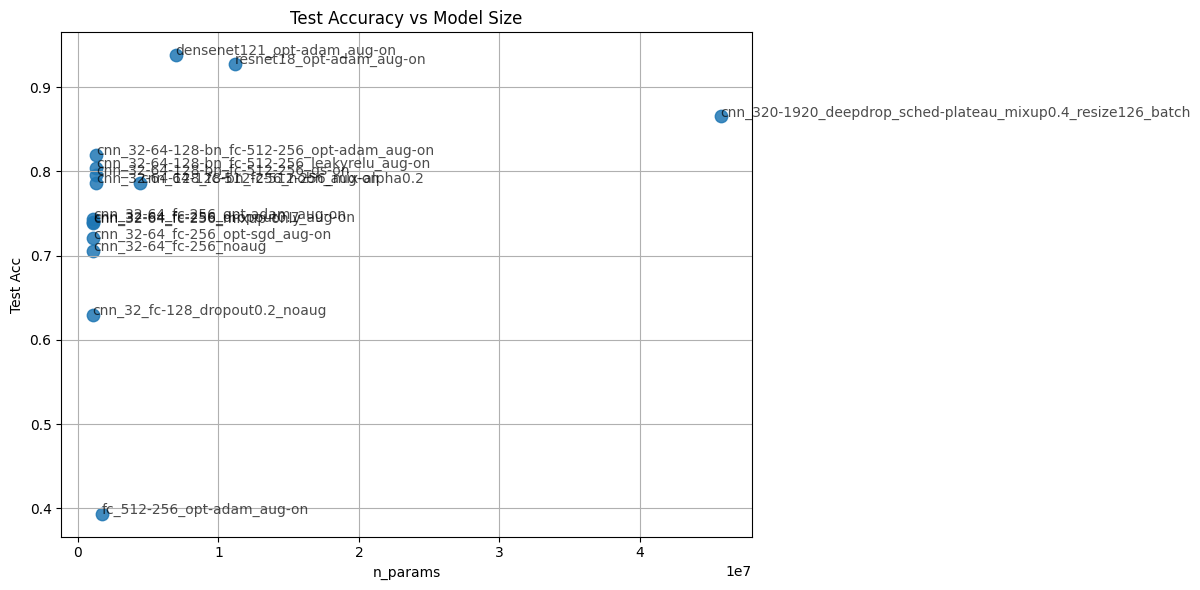

In [9]:
plot_scatter_metrics(
    df_ext_feauters_metrics,
    x_col='n_params',
    y_col='Test Acc',
    label_col='Model',
    title='Test Accuracy vs Model Size'
)

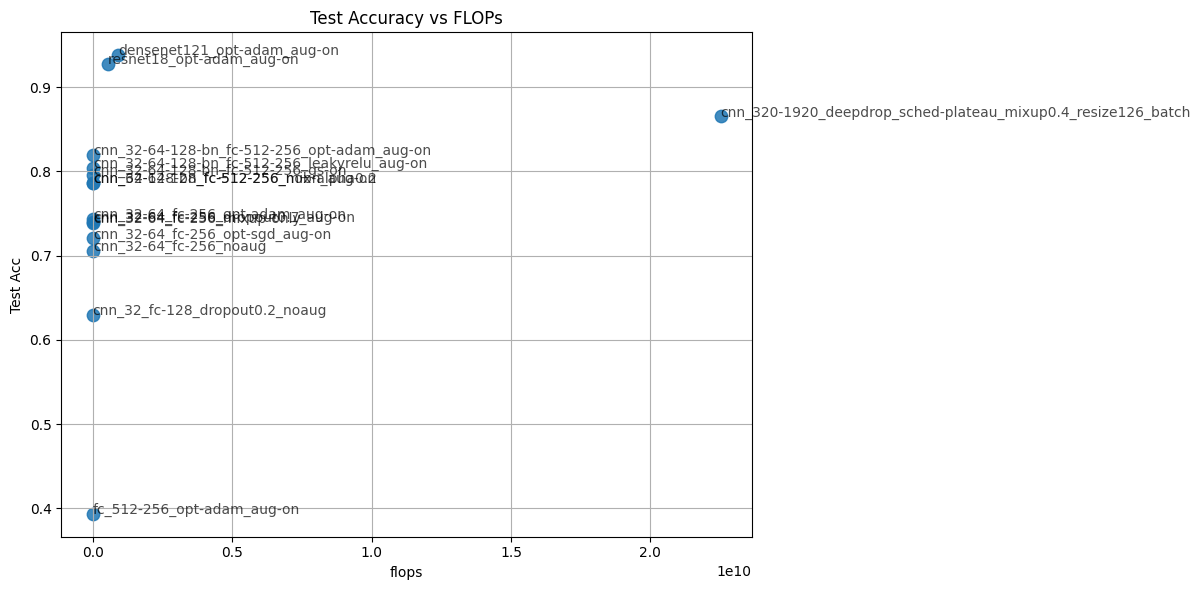

In [10]:
plot_scatter_metrics(
    df_ext_feauters_metrics,
    x_col='flops',
    y_col='Test Acc',
    label_col='Model',
    title='Test Accuracy vs FLOPs'
)

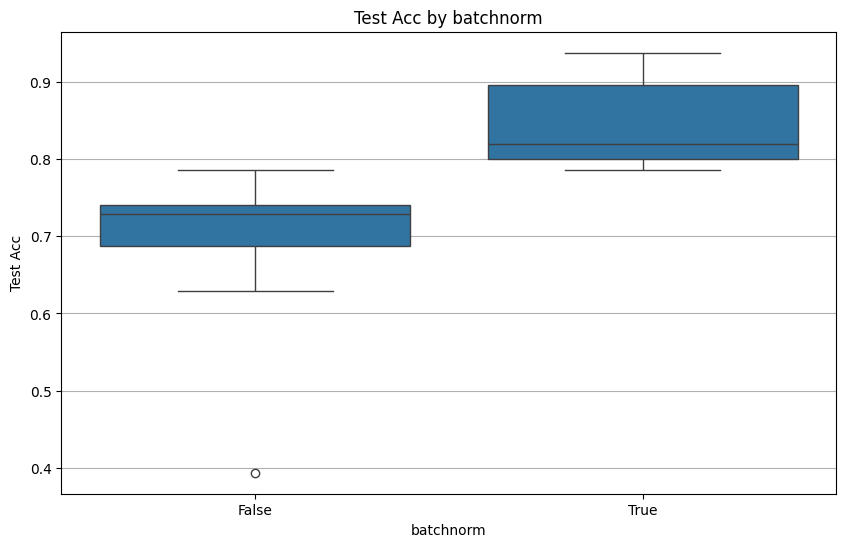

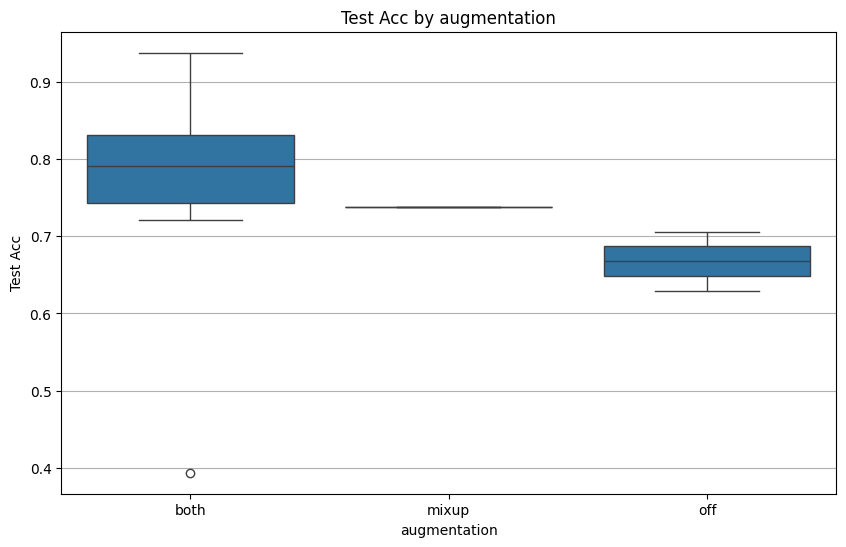

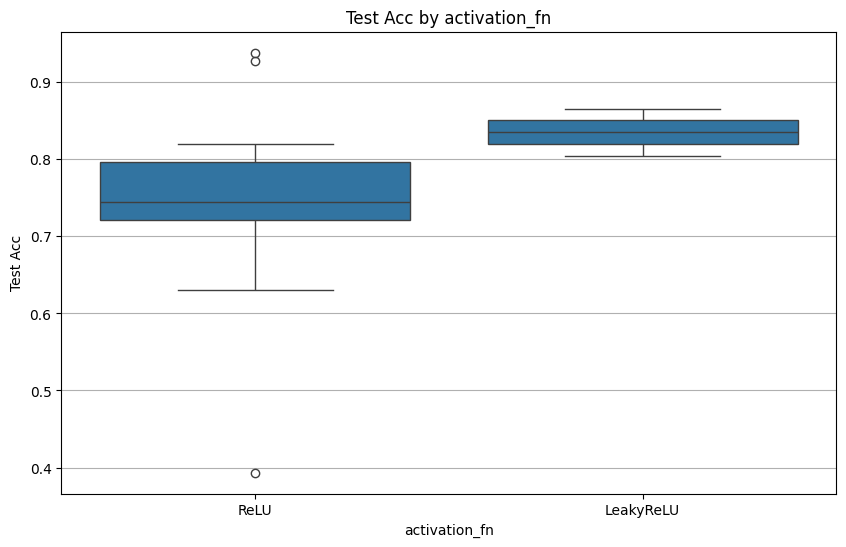

In [11]:
plot_boxplot_by_category(df_ext_feauters_metrics, "batchnorm")
plot_boxplot_by_category(df_ext_feauters_metrics, "augmentation")
plot_boxplot_by_category(df_ext_feauters_metrics, "activation_fn")

#### Dropout Rate vs Overfitting Gap

This plot illustrates the relationship between the average dropout rate and the difference between training and validation accuracy (Overfitting Gap). 

The goal is to analyze how dropout affects overfitting:
- A high Overfitting Gap indicates overfitting,
- A low or negative value may indicate underfitting or strong re


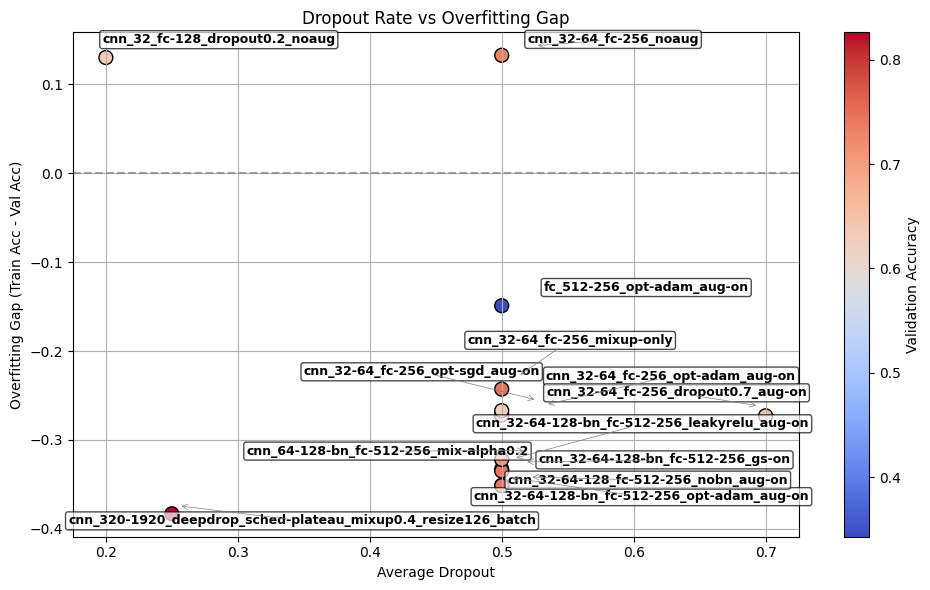

In [33]:
import ast

def parse_dropout(value):
    """
    Safely parse dropout values that might be stored as string representations of lists.
    Returns a list of floats or None.
    """
    if value is None or value == "N/A":
        return None
    if isinstance(value, (float, int)):
        return [float(value)]
    if isinstance(value, list):
        return value
    if isinstance(value, str):
        try:
            # check if string is a list
            parsed = ast.literal_eval(value)
            if isinstance(parsed, (list, tuple)):
                return [float(x) for x in parsed]
            
            return [float(parsed)]
        except Exception:
            return None
    return None

df_models["Dropout Avg"] = df_models.apply(
    lambda row: np.mean(parse_dropout(row["Dropout"])) 
        if parse_dropout(row["Dropout"]) is not None else np.nan,
    axis=1
)
plot_dropout_vs_overfit(df_models)

In [34]:
print(df_models[["Model", "Dropout Avg", "Overfit Gap"]])


                                                Model  Dropout Avg  \
0                         densenet121_opt-adam_aug-on          NaN   
1                            resnet18_opt-adam_aug-on          NaN   
2   cnn_320-1920_deepdrop_sched-plateau_mixup0.4_r...         0.25   
3         cnn_32-64-128-bn_fc-512-256_opt-adam_aug-on         0.50   
4        cnn_32-64-128-bn_fc-512-256_leakyrelu_aug-on         0.50   
5                         cnn_32-64_fc-256_mixup-only         0.50   
6                   cnn_32-64-128-bn_fc-512-256_gs-on         0.50   
7                cnn_32-64-128_fc-512-256_nobn_aug-on         0.50   
8                              cnn_32-64_fc-256_noaug         0.50   
9               cnn_64-128-bn_fc-512-256_mix-alpha0.2         0.50   
10                   cnn_32-64_fc-256_opt-adam_aug-on         0.50   
11                 cnn_32-64_fc-256_dropout0.7_aug-on         0.70   
12                     cnn_32_fc-128_dropout0.2_noaug         0.20   
13                  

#### Model Efficiency

This chart compares models by their **efficiency**, defined as:

$
\text{Efficiency} = \frac{\text{Validation Accuracy}}{\text{Average Epoch Time (s)}}
$

Higher values indicate models that achieve good accuracy with less training time per epoch.


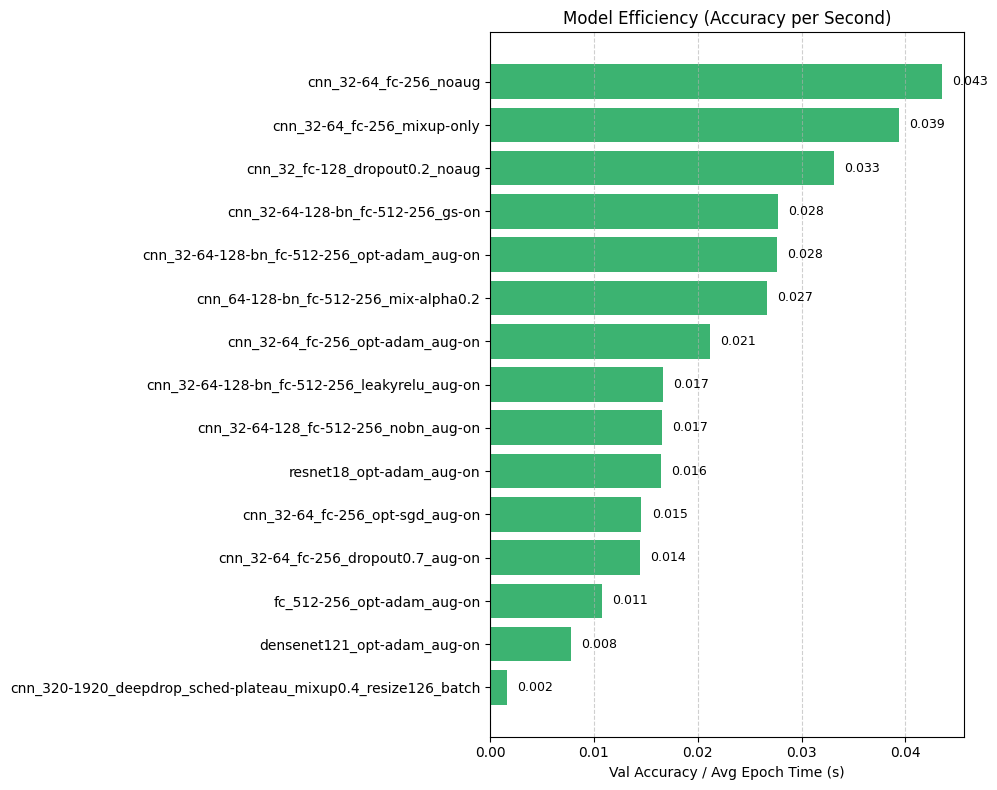

In [35]:
df_models["Efficiency"] = df_models["Val Acc"] / df_models["Avg Epoch Time (s)"]

plot_efficiency(df_models)

#### Model Accuracy by Architecture Type

This boxplot shows the distribution of model accuracy grouped by architecture type: **CNN** (Convolutional Neural Networks) and **FC** (Fully Connected networks).

Two metrics are shown:
- **Val Acc**: Validation Accuracy
- **Test Acc**: Test Accuracy

The plot highlights how CNN-based architectures consistently outperform FC networks in both validation and test accuracy. The spread also indicates variability within CNNs, while FC models cluster closer together with lower performance.


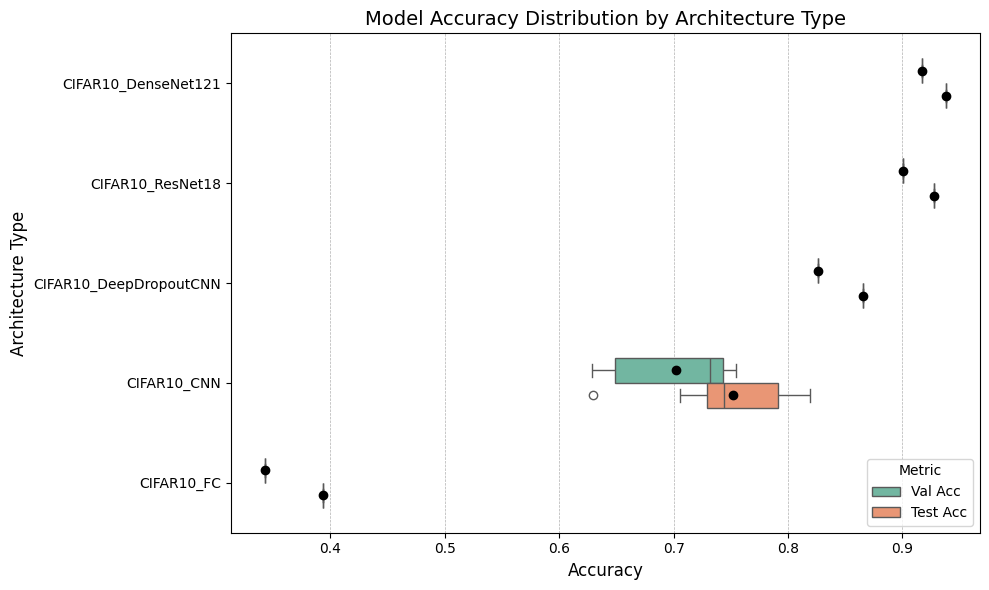

In [12]:
plot_group_accuracy(df_models)

### Model Comparison and Meta-Analysis

This section summarizes the large-scale meta-analysis of CIFAR-10 models trained with diverse architectures and hyperparameters.  
The results below are based on 15+ runs, each with detailed logging of configuration, training metrics, and final evaluation scores.

---

#### **Key Analyses and Visualizations**

- **Correlation Heatmap:**  
  Explores relationships between model structure (number of layers, size, FLOPs), training settings (augmentation, batchnorm, activation), and key metrics (test accuracy, overfitting, training speed).
- **Feature Importance:**  
  Using XGBoost, we assessed which model/hyperparameter features most strongly affect test accuracy. For CNNs, the number of fully connected layers and use of data augmentation dominate, while the influence of batchnorm, optimizer, and regularization is more subtle.
- **Scatterplots:**  
  - **Test Accuracy vs Training Speed:**  
    Highlights the trade-off between final accuracy and training time per epoch; larger models may not always be efficient.
  - **Test Accuracy vs Model Size (n_params):**  
    Reveals the "sweet spot" for parameter count—where further increases yield diminishing returns.
  - **Test Accuracy vs FLOPs:**  
    Shows compute cost versus accuracy. Some architectures (e.g., DeepDropout) have high FLOPs without proportionally better results.
- **Boxplots:**  
  - By **BatchNorm:**  
    Models with batch normalization consistently outperform those without.
  - By **Augmentation:**  
    Combined augmentation strategies ("both") generally yield higher and more robust accuracy.
  - By **Activation Function:**  
    LeakyReLU provided a slight edge over vanilla ReLU in our experiments.

---

#### **Key Insights**

- **Architecture still dominates:**  
  Model type and structure remain the main drivers of performance. However, within a single architecture family (e.g., CNN), hyperparameter choices like augmentation and layer configuration make a significant difference.
- **BatchNorm and augmentation matter:**  
  Their inclusion increases both peak accuracy and stability.
- **Efficiency matters:**  
  Some models (ResNet18, DenseNet121) achieve top accuracy with reasonable resource usage, while others (very deep or “heavy” CNNs) provide only marginal gains at high computational cost.
- **Feature importance is context-sensitive:**  
  When analyzing only CNNs, regularization and architectural tweaks become more relevant.

---

#### **Next Steps**

- **Automate broader sweeps:**  
  Automate the generation and logging of new architectures for even richer meta-analysis (e.g., Optuna or grid/random search).
- **Expand the analytics:**  
  Consider per-class breakdowns (F1, confusion matrix), learning curves, and further efficiency plots.
- **Integrate into documentation:**  
  Update README and analytical report with meta-visualizations and findings for reproducibility and knowledge sharing.

---

*This analysis platform now allows fast, data-driven comparison of arbitrary architectures and training setups—enabling deep model exploration and robust research conclusions.*


#### 🔍 Comparison of Two Models

This section compares the selected models based on:
- **Confusion Matrices**: For an overview of misclassifications.
- **Per-Class F1-Scores**: Displayed in a sortable table.
- **F1 Difference Bar Plot**: Δ F1 between the two models per class (positive = better performance of second model).

⚙️ To compare models:
1. Run `interactive_model_comparison(test_results, class_names)` to display the UI.
2. Select models and click "Compare Models".
3. After each comparison, re-run the function to reset the interface.

✅ Output is cleared before each comparison to prevent clutter or duplicate visualizations.

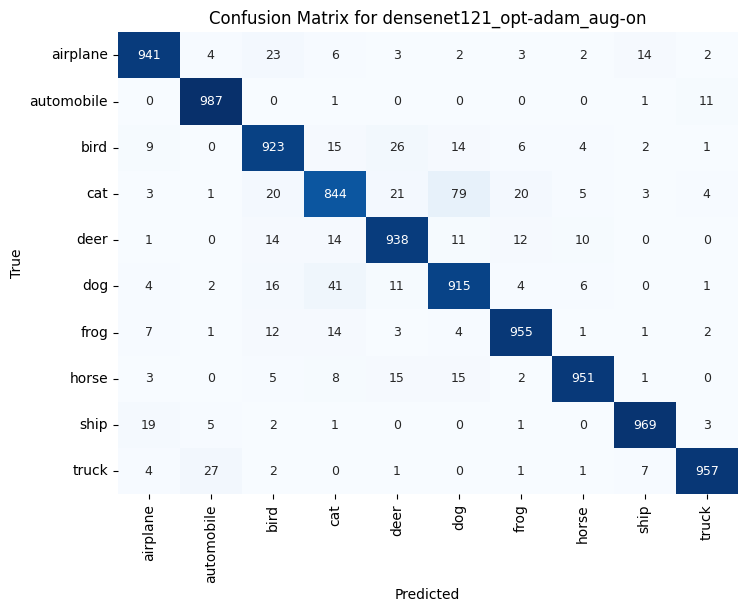

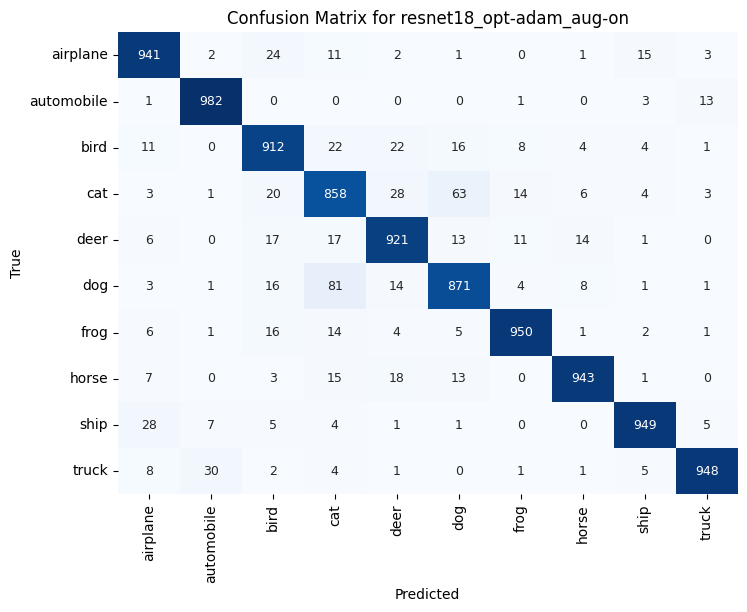


📊 F1-score comparison by class:



,densenet121_opt-adam_aug-on,resnet18_opt-adam_aug-on,Δ F1
frog,0.953094,0.955254,0.0022
automobile,0.973853,0.970356,-0.0035
truck,0.966179,0.960000,-0.0062
horse,0.960606,0.953488,-0.0071
bird,0.915221,0.905211,-0.0100
airplane,0.945254,0.934459,-0.0108
deer,0.929633,0.915962,-0.0137
ship,0.969970,0.956171,-0.0138
dog,0.897059,0.878467,-0.0186
cat,0.868313,0.846989,-0.0213


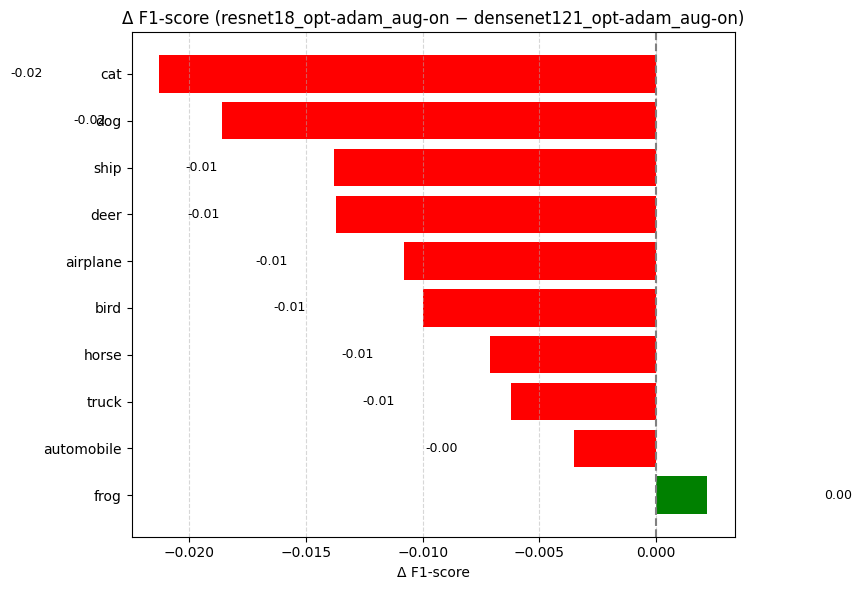

In [37]:
interactive_model_comparison(test_results, class_names)